# Project: Investigation of an European football database

## Table of Contents
<ol>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<ol>
<li><a href="#wrangling1">Importing the data</a></li>
<li><a href="#wrangling2">Inspecting the data</a></li>
<li><a href="#wrangling3">Data cleaning</a></li>
</ol>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<ol>
<li><a href="#eda1">Question 1: Home advantage</a></li>
<li><a href="#eda2">Question 2: Effect of ball possession</a></li>
<li><a href="#eda3">Question 3: Effect of team formation</a></li>
</ol>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ol>

<a id='intro'></a>
## 1. Introduction

The database I have chosen for the analysis is the one called "European Soccer Database", which is a collection of matches', teams' and players' data for European association football (or soccer in American English). As it can be seen in the website mentioned in ref. <a href="#ref1">[1]</a>, the database contains data from more than 25000 matches, spread over nine seasons, including detailed information on different match events, such as goal types and ball possession. In addition, it includes the squad formation for a large number of matches, as well as other interesting information such as betting odds and players' attributes extracted from EA Sports FIFA video game.

The size and extent of this database offer countless possibilities for investigation, particularly for a person with such a passion for football as myself. For this reason, I have used the information available on the Kaggle website to review the content and variables of the database in order to get myself familiar with it and decide which points I would like to investigate. After this preliminary check, I reached the conclusion that in my analysis I would like to try to answer the following questions:

<ul>
<li>Do teams playing at home win more matches? Do they also score more goals than the away teams?</li>
<li>What is the impact of the ball possession on the final result? Does more possession lead to more victories? Does more possession also lead to more goals for and less goals against?</li>
<li>How does the squad formation influence the results? Do some formations have a significantly larger percentage of victories than others? Do formations with more forwards lead to more goals scored? And do formations with more defenders result in less goals conceded?</li>
</ul>

The reason for choosing to focus on these topics is that, when reading about football in the press or when discussing it with friends, these points are frequently mentioned as being the key factors explaining the performance of a given team. In particular, the ball possession has been brought to the spotlight in the past decades with the irruption of a new wave in football &mdash; embodied by managers such as Pep Guardiola and Arsène Wenger &mdash; which emphasizes the importance of controlling the ball possession as the best means to achieve victory. 

The intention of this investigation is thus not so much to answer why playing home or controlling the ball possession represents an advantage, but to find out whether these statements are really backed by evidence or not.

In [1]:
# The first step is to load the basic packages that I will use throughout the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# I also include the following line to ensure that the graphs are plotted as output of their corresponding cells
%matplotlib inline

<a id='wrangling'></a>
## 2. Data Wrangling

This section is meant to cover all the necessary steps to go from the initial database (in its original format) to a final dataset suitable for the analysis. In particular, I will need import the data into a convenient format, check its cleanliness and then trim it to be able to investigate the abovementioned points.

<a id='wrangling1'></a>
###  2.a. Importing the data

In this section, I import the original database into a Pandas DataFrame. For this, I make use of a method suggested in ref. <a href="#ref2">[2]</a>, which allows for an efficient reading and loading of SQL databases.

In [2]:
# Import package to read SQLite databases
import sqlite3

In [3]:
# Read SQLite DB by creating a connection
db_path = '../Files/database.sqlite'
conn = sqlite3.connect(db_path)

In [4]:
# Print out the name of the tables contained in the database
pd.read_sql("SELECT * FROM sqlite_master WHERE type='table';", conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


As mentioned before, since the database is available in Kaggle (ref. <a href="#ref1">[1]</a>), I have performed a preliminary check of the different data tables available, as well as the variables contained in each of them.

Given the scope of the analysis that I will perform, the only tables required are the following:
  - Team
  - League
  - Country
  - Match

The first table &mdash; i.e. Team &mdash; can be imported as such into a Pandas DataFrame. For the other tables I will use a slightly different approach, which I will explain below.

In [5]:
# Create a DataFrame with the Team table and print out some rows
df_teams = pd.read_sql_query("SELECT * FROM Team", conn)
df_teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


The table seems to have been loaded correctly.

For the League and Country tables, I will merge them both into one dataframe, as they contain basically the same set of information: country name, league name and ID number; which can be related one to one, making it easy and practical to have in an unique dataframe.

For this I will use a property from SQL databases, which allows creating new variables based on other tables' data while importing the data (see ref. <a href="#ref2">[2]</a>).

In [6]:
# Create a DataFrame with the leagues' and countries' names and the corresponding ID numbers
df_leagues = pd.read_sql("""SELECT id, country_id, 
                         (name) league_name,
                         (SELECT name FROM Country WHERE id = country_id) country_name
                         FROM League
                         """, conn)
# Print out list of available countries and leagues
df_leagues

,id,country_id,league_name,country_name
0,1,1,Belgium Jupiler League,Belgium
1,1729,1729,England Premier League,England
2,4769,4769,France Ligue 1,France
3,7809,7809,Germany 1. Bundesliga,Germany
4,10257,10257,Italy Serie A,Italy
5,13274,13274,Netherlands Eredivisie,Netherlands
6,15722,15722,Poland Ekstraklasa,Poland
7,17642,17642,Portugal Liga ZON Sagres,Portugal
8,19694,19694,Scotland Premier League,Scotland
9,21518,21518,Spain LIGA BBVA,Spain


It is worth noting that I have also changed the name of the leagues' name variable from 'name' to 'league_name' while importing the data. This is only for the sake of clarity.

Next, I will import the Match table following a similar process as the one above. Since the Match table is quite large, I will only import the columns (or variables) that can be of interest for the analysis (e.g. I will not upload any of the betting variables, as I will not be looking into that).

In [7]:
# Create a DataFrame with the Match table, importing only the relevant variables and adding the names of leagues, countries and teams
df_matches = pd.read_sql("""SELECT id, league_id,
                         (SELECT name FROM League WHERE id = league_id) league_name,
                         (SELECT name FROM Country WHERE id = league_id) country_name,
                         stage, season, date, match_api_id, home_team_api_id,
                         (SELECT team_long_name FROM Team WHERE team_api_id = home_team_api_id) home_team,
                         (SELECT team_short_name FROM Team WHERE team_api_id = home_team_api_id) home_team_short,
                         away_team_api_id,
                         (SELECT team_long_name FROM Team WHERE team_api_id = away_team_api_id) away_team,
                         (SELECT team_short_name FROM Team WHERE team_api_id = away_team_api_id) away_team_short,
                         home_team_goal, away_team_goal, goal, shoton, shotoff, foulcommit, card, cross, corner, possession,
                         home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, home_player_Y11,
                         away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4, away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10, away_player_Y11
                         FROM Match m
                         ORDER BY date;
                         """, conn)

In [8]:
# Print out the first rows of the DataFrame
df_matches.head()

,id,league_id,league_name,country_name,stage,season,date,match_api_id,home_team_api_id,home_team,...,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11
0,24559,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-18 00:00:00,486263,10192,BSC Young Boys,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24560,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-19 00:00:00,486264,9930,FC Aarau,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24561,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486265,10199,FC Luzern,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24562,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486266,7955,Neuchâtel Xamax,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24613,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486267,9931,FC Basel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As it can be seen in the website containing the database, the Match table does not contain originally the names of the leagues, countries and teams, but only the corresponding IDs. For this reason, I have used the same method as for the League table to add the following variables: league name, country name, home team name (long and short) and away team name (long and short). This method is an adaptation of the one found in ref. <a href="#ref2">[2]</a>.

When first importing the data, my first idea was to import the complete table into a dataframe, and then add new columns with the different names (leagues, countries...) by using list comprehensions. However, measuring the execution time of both methods it turned out that adding the variables while importing the data was much faster than having to add individual columns for each new variable (6 in total). In addition, this method allows you to tailor the variables that you want to import. The only drawback is that you have to be very careful not to forget or mistype any variable.

<a id='wrangling2'></a>
### 2.b. Inspecting the data

The first thing I wanted to look at is the amount of matches data available, in total and separated by country:

In [9]:
for country in df_leagues.country_name:
    no_seasons = df_matches.season[df_matches.country_name == country].nunique()
    no_matches = df_matches.id[df_matches.country_name == country].size
    print "For %s there are %d seasons of data and %d matches in total." % (country, no_seasons, no_matches)

print 
print "In total, there is data for %d matches available." % (df_matches.id.size)

For Belgium there are 8 seasons of data and 1728 matches in total.
For England there are 8 seasons of data and 3040 matches in total.
For France there are 8 seasons of data and 3040 matches in total.
For Germany there are 8 seasons of data and 2448 matches in total.
For Italy there are 8 seasons of data and 3017 matches in total.
For Netherlands there are 8 seasons of data and 2448 matches in total.
For Poland there are 8 seasons of data and 1920 matches in total.
For Portugal there are 8 seasons of data and 2052 matches in total.
For Scotland there are 8 seasons of data and 1824 matches in total.
For Spain there are 8 seasons of data and 3040 matches in total.
For Switzerland there are 8 seasons of data and 1422 matches in total.

In total, there is data for 25979 matches available.


As it can be seen above, there are 8 seasons of data available for each country, with a maximum of 3040 matches per country. This is the case for leagues with 20 teams, such as England or Spain: 10 matches per stage, times 38 league stages, times 8 seasons, equals 3040 matches in total.
Other countries, such as Germany or the Netherlands, have leagues with 18 teams, which provides a total of 2448 matches in 8 seasons.

An interesting case is Italy, where the league has 20 teams, which would account for 3040 matches in 8 seasons. However, in the data we can see that there are only 3017 matches available. To take a look at this more closely, I will print the number of matches available per season in Italy.

In [10]:
print "Number of matches available in each season for the Italian league:\n"
for season in df_matches[df_matches.country_name == 'Italy'].season.unique():
    no_matches = df_matches.id[(df_matches.country_name == 'Italy') & (df_matches.season == season)].size
    print "Season %s: %d matches" % (season, no_matches)

Number of matches available in each season for the Italian league:

Season 2008/2009: 380 matches
Season 2009/2010: 380 matches
Season 2010/2011: 380 matches
Season 2011/2012: 358 matches
Season 2012/2013: 380 matches
Season 2013/2014: 380 matches
Season 2014/2015: 379 matches
Season 2015/2016: 380 matches


What we can see is that there are two seasons with less matches recorded than the usual number of matches for a 20-team league. The reason for this might be that the original source from which the database was constructed did not contain the data for these matches (most likely), or because in the corresponding season not all matches were played. The latter could happen if a team gets suspended during the course of a season &mdash; for non-payment of the wages to their players, for example.

In any case, it is interesting to note that not all countries are represented to the same amount in the database, which indicates that we need to be careful when comparing quantities between the different leagues and only work in relative magnitudes &mdash; e.g. mean of scored goals instead of total number of goals.

The next thing I looked at are the variable types of the different columns. This will quickly provide me with an idea of the content of the columns.

In [11]:
# Check data types of the different columns
df_matches.dtypes

id                    int64
league_id             int64
league_name          object
country_name         object
stage                 int64
season               object
date                 object
match_api_id          int64
home_team_api_id      int64
home_team            object
home_team_short      object
away_team_api_id      int64
away_team            object
away_team_short      object
home_team_goal        int64
away_team_goal        int64
goal                 object
shoton               object
shotoff              object
foulcommit           object
card                 object
cross                object
corner               object
possession           object
home_player_Y1      float64
home_player_Y2      float64
home_player_Y3      float64
home_player_Y4      float64
home_player_Y5      float64
home_player_Y6      float64
home_player_Y7      float64
home_player_Y8      float64
home_player_Y9      float64
home_player_Y10     float64
home_player_Y11     float64
away_player_Y1      

As it can be seen, the dataframe contains three different types of variables: integers, float numbers and strings (called objects).

For the analysis that I want to carry out, I will need the following data: goals scored per team, ball possession and team formation. The information concerning the goals can be found in the variables 'home_team_goal' and 'away_team_goal'. I will print them out to see if they are correctly defined.

In [12]:
# Print out the home and away goal variables
print_list = ['home_team_goal', 'away_team_goal']
df_matches[print_list]

,home_team_goal,away_team_goal
0,1,2
1,3,1
2,1,2
3,1,2
4,1,0
5,1,2
6,1,0
7,2,1
8,0,2
9,2,0


The two variables seem to be correctly defined. Nevertheless, I will also check if there are some NaNs in these columns, in case the goals have not been correctly stored for some matches.

In [13]:
# Check if there are NaNs in the goals information
print df_matches[print_list][df_matches['home_team_goal'].isnull()]
print df_matches[print_list][df_matches['away_team_goal'].isnull()]

Empty DataFrame
Columns: [home_team_goal, away_team_goal]
Index: []
Empty DataFrame
Columns: [home_team_goal, away_team_goal]
Index: []


There are no NaNs in any of these two variables, which means that all the matches (or rows) contain the number of goals of both teams.

Next, I want to check the information concerning the ball possession. For this, I will investigate the variable names 'possession'.

In [14]:
# Print out the variable containing ball possession
print_list = 'possession'
df_matches[print_list]

0                                                     None
1                                                     None
2                                                     None
3                                                     None
4                                                     None
5                                                     None
6                                                     None
7                                                     None
8                                                     None
9                                                     None
10                                                    None
11                                                    None
12                                                    None
13                                                    None
14                                                    None
15                                                    None
16                                                    No

There are two interesting facts that can be observed here:

 - One is that not all rows contain information about ball possession &mdash; i.e. they contain a "None".
 - The second one is that, for the cells which do contain possession data, the information is given as XML strings.

This means that I will need to extract the possession data into a more readable format &mdash; e.g. float numbers &mdash; by defining a function. I will do this it in the next section: "Data cleaning".

However, before that, I would like to see how many points of possession data do I actually have and check whether they are distributed following some pattern &mdash; e.g. only given for some countries.

In [15]:
# Print how many points with possession data are available
df_matches['id'][df_matches['possession'].notnull()].size

14217

In [16]:
# Print how many matches with possession data are given for each country
for country in df_leagues['country_name']:
    matches_w_possession = df_matches['id'][(df_matches['country_name'] == country) 
                                            & (df_matches['possession'].notnull())].size
    matches_total = df_matches['id'][df_matches['country_name'] == country].size
    print "For %s there are %d matches with possession data out of %d matches." % (country, matches_w_possession, 
                                                                                   matches_total)
print 
print "In total, there are %d matches with possession data out of %d matches." % (df_matches['id'][df_matches['possession'].notnull()].size,
                                                                                  df_matches['id'].size)

For Belgium there are 0 matches with possession data out of 1728 matches.
For England there are 3040 matches with possession data out of 3040 matches.
For France there are 2026 matches with possession data out of 3040 matches.
For Germany there are 2448 matches with possession data out of 2448 matches.
For Italy there are 3014 matches with possession data out of 3017 matches.
For Netherlands there are 530 matches with possession data out of 2448 matches.
For Poland there are 7 matches with possession data out of 1920 matches.
For Portugal there are 0 matches with possession data out of 2052 matches.
For Scotland there are 13 matches with possession data out of 1824 matches.
For Spain there are 3039 matches with possession data out of 3040 matches.
For Switzerland there are 100 matches with possession data out of 1422 matches.

In total, there are 14217 matches with possession data out of 25979 matches.


It seems that there are 14217 matches which contain possession data, this represents around 54% of all the matches. Also, we can see that the possession data is not evenly distributed for all the countries. I will take this into account when analyzing the ball possession data, as I will try to focus on those countries which contain an almost complete base of matches with possession data &mdash; i.e. England, Germany, Italy and Spain &mdash; to try to avoid introducing additional noise or outliers into the analysis.

Finally, I want to focus on the information concerning the squad formation of each team. As it can be seen in the list of variables provided in ref. <a href="#ref1">[1]</a>, there is no variable providing the team formation as such. However, there are a series of variables named 'home_player_Yi' and 'away_player_Yi' (where i are integers from 1 to 11), which represent the position of the player along the length of the field, as it can be seen in the following extract from ref. <a href="#ref3">[3]</a>:

>*The X and Y variables identify the position of the player on the field. The field is divided X and Y coordinates. The X coordinates are on the goalline rnanging 1-9, and the Y coordinates are along the length of the field ranging 1-11.
All keepers have coordinates (1,1), while all field players can have an X-coordinate 2-9 and an Y-coordinate 2-11.*

In the next section, I will define the required functions to obtain the numerical values of the ball possession and the squad formations.

<a id='wrangling3'></a>
### 2.c. Data Cleaning

As mentioned above, the first step of the data cleaning process is to determine the possession percentages of the home and away teams for each match, which need to be read from the XML strings given in the 'possession' column.

For this, I have created a function which reads the XML information for each cell and returns the possession percentage of the home team where available, otherwise, a NaN is returned.

One point I discovered when creating the function is that the database contains usually several possession values for each match, i.e. the home and away possession percentages during several stages of the match. An example is given in the next cell: (method to print found in ref. <a href="#ref4">[4]</a>)

In [17]:
# Print out a random possession point showing the XML string format
from lxml import etree
xml_str = df_matches['possession'][df_matches.country_name == 'England'].iloc[115]
root = etree.fromstring(xml_str)
print etree.tostring(root, pretty_print=True)

<possession>
  <value>
    <comment>60</comment>
    <event_incident_typefk>352</event_incident_typefk>
    <elapsed>25</elapsed>
    <subtype>possession</subtype>
    <sortorder>5</sortorder>
    <awaypos>40</awaypos>
    <homepos>60</homepos>
    <n>73</n>
    <type>special</type>
    <id>481430</id>
  </value>
  <value>
    <comment>67</comment>
    <elapsed_plus>2</elapsed_plus>
    <event_incident_typefk>352</event_incident_typefk>
    <elapsed>45</elapsed>
    <subtype>possession</subtype>
    <sortorder>0</sortorder>
    <awaypos>33</awaypos>
    <homepos>67</homepos>
    <n>125</n>
    <type>special</type>
    <id>481700</id>
  </value>
  <value>
    <comment>58</comment>
    <event_incident_typefk>352</event_incident_typefk>
    <elapsed>70</elapsed>
    <subtype>possession</subtype>
    <sortorder>1</sortorder>
    <awaypos>42</awaypos>
    <homepos>58</homepos>
    <n>203</n>
    <type>special</type>
    <id>482230</id>
  </value>
  <value>
    <comment>56</comment>
    <ela

The different possession percentages seem to be given for different elapsed times of the match, however, from the raw data it is not possible to determine whether they have been calculated during the whole span of the elapsed time given or only between the corresponding time and the previous one.
As an example, based on the example above, do the values given for elapsed time = 90 correspond to:
<ul>
<li>The possession percentages during the whole 90 minutes of the match?</li>
<li>The possession between minutes 70 and 90?</li>
</ul>

I have tried to look online for documentation on the database which could shed some light on this, but I have not been able to find any explanation. Therefore, I have made the assumption that the possession given for each time corresponds to the possession percentage during the whole match up to that point (i.e. the first option from above).

Since the one of objectives of the study is to assess the influence of the possession on the outcome of the matches, I want to get the overall possession percentage for each match. For this reason, the function I have defined retrieves only the last possession value provided in the XML data, as I have assumed that it represents the possession distribution during most of the match.

In [18]:
import xml.etree.ElementTree as ET

def get_home_possession(xml_string):
    # Return a NaN if possession data is not defined
    if xml_string == None:
        return np.NaN
    # Parse the information from a XML string to a XML Element
    tree = ET.fromstring(xml_string)
    # Return a NaN if no values are given in the possession data
    if len(tree.findall('value')) == 0:
        return np.NaN
    # Get the last value given for home possession and return the value 
    home_possession = [int(child.find('homepos').text) for child in tree.iter('value') 
                       if (child.find('homepos') is not None)][-1]
    return home_possession

In [19]:
# Get the possession percentages for the home teams
df_matches['home_possession'] = df_matches['possession'].apply(get_home_possession)
# Compute the away possession percentages by subtracting the home possession from 100%
df_matches['away_possession'] = 100 - df_matches['home_possession']

In order to simplify the code (and make it faster), I have decided to only read out the values of the home team's possession and compute the away team's one by subtracting the 'home_possession' values from 100%. Next, I will print out some lines of these two new columns to check that the values are correctly stored.

In [20]:
# Print out some values of the home and away possession columns
print_list = ['home_possession', 'away_possession']
df_matches[print_list]

,home_possession,away_possession
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


The variables seem correctly defined, with numerical numbers where possession values are given in the database and NaNs in the rows where no data is given. Nevertheless, I would like to find out how many possession points do we finally have.

In [21]:
# Print how many points with possession data are available (i.e. not NaNs)
df_matches['id'][df_matches['home_possession'].notnull()].size

8419

This number is considerably lower than the one obtained above (14217). This is due to the fact that the number shown in the previous section was reflecting all the rows which contained some sort of XML string. When writing the function to retrieve the numerical values, however, I realized that some of the rows which contained a XML string did not contain numerical possession values, so I decided to return a NaN in these cases as well. This reduces the percentage of available possession data to roughly 32% of the total amount of points. In any case, this should be enough to perform the intended analysis.

I would also like to print out the number of possession points available per country, as done above, but with the final data.

In [22]:
# Print how many matches with possession data are given for each country
for country in df_leagues['country_name']:
    matches_w_possession = df_matches['id'][(df_matches['country_name'] == country) 
                                            & (df_matches['home_possession'].notnull())].size
    matches_total = df_matches['id'][df_matches['country_name'] == country].size
    print "For %s there are %d matches with possession data out of %d matches." % (country, matches_w_possession, 
                                                                                   matches_total)

For Belgium there are 0 matches with possession data out of 1728 matches.
For England there are 3035 matches with possession data out of 3040 matches.
For France there are 764 matches with possession data out of 3040 matches.
For Germany there are 1119 matches with possession data out of 2448 matches.
For Italy there are 1534 matches with possession data out of 3017 matches.
For Netherlands there are 319 matches with possession data out of 2448 matches.
For Poland there are 7 matches with possession data out of 1920 matches.
For Portugal there are 0 matches with possession data out of 2052 matches.
For Scotland there are 13 matches with possession data out of 1824 matches.
For Spain there are 1628 matches with possession data out of 3040 matches.
For Switzerland there are 0 matches with possession data out of 1422 matches.


What we can see is that the number of available points has been considerably reduced for all countries except for England, which has a very representative database. For countries like Spain, Italy or Germany, while the amount of available data has decreased, the database still contains a large amount of data, around 50%, which should be enough for the analysis. Nevertheless, I will have to take this into account when analyzing the data, as it might introduce a bias in the results &mdash; e.g. if the possession is only monitored for some teams.

Next, I want to obtain the formation of both home and away teams. For this, as mentioned above, I will use the information stored in the variables "home_player_Yi" and "away_player_Yi", which represent the position of each player along the length of the field, and thus serves to categorize each player into the following categories (or formation lines): goalkeeper, defender, midfielder and attacker.

The first step that I have done is to get the number of players in each formation line. For this, I have created a function that loops through all eleven players of each team and, depending on the value of their Y position, sets them in one of the lines. The possible values of Y go from 1 to 11 and, based on the information shown in ref. <a href="#ref3">[3]</a>, I have decided to categorize them as follows:
 - Goalkeeper: $Y=1$
 - Defender: $2\leq Y\leq 4 $
 - Midfielder: $5\leq Y\leq 7$
 - Forward: $8\leq Y\leq 11$

In [23]:
def get_players_per_line(df, iter_list):
    num_goalkeepers, num_defenders, num_midfielders, num_forwards = 0, 0, 0, 0
    for player_key in iter_list:
        # Return 99 if at least one of the players Y-position is not given (i.e. the team formation cannot be derived)
        if np.isnan(df[player_key]):
            return 99, 99, 99, 99 
        # Add a goalkeeper
        elif df[player_key] == 1:
            num_goalkeepers += 1
        # Add a defender
        elif  2 <= df[player_key] <= 4:
            num_defenders += 1
        # Add a midfielder
        elif  5 <= df[player_key] <= 8:
            num_midfielders += 1
        # Add a forward
        elif  9 <= df[player_key] <= 11:
            num_forwards += 1
    return num_goalkeepers, num_defenders, num_midfielders, num_forwards

In [24]:
# Define the list with the column names and get the number of players in each line for the home team
home_list = [key for key, value in df_matches.iteritems() if 'home_player_Y' in key]
(df_matches['home_goalkeepers'], df_matches['home_defenders'], df_matches['home_midfielders'],
   df_matches['home_forwards']) = zip(*df_matches.apply(lambda x: get_players_per_line(x, home_list), axis=1))

# Define the list with the column names and get the number of players in each line for the away team
away_list = [key for key, value in df_matches.iteritems() if 'away_player_Y' in key]
(df_matches['away_goalkeepers'], df_matches['away_defenders'], df_matches['away_midfielders'],
   df_matches['away_forwards']) = zip(*df_matches.apply(lambda x: get_players_per_line(x, away_list), axis=1))

In order to see whether the variables have been stored correctly, I will print out some rows of the new variables in the next cell. However, it is worth noting that I have introduced a feature in the function that returns the number 99 whenever one of the players of the team is given as NaN in the original data. I have done this in order to get only those formations which can be fully defined &mdash; i.e. all eleven players &mdash; discarding any data in which at least player is not correctly defined, as it would not be useful for my analysis.

In [25]:
# Print out some rows of the new variables
print_list = ['home_goalkeepers', 'home_defenders', 'home_midfielders', 'home_forwards',
              'away_goalkeepers', 'away_defenders', 'away_midfielders', 'away_forwards']
df_matches[print_list]

,home_goalkeepers,home_defenders,home_midfielders,home_forwards,away_goalkeepers,away_defenders,away_midfielders,away_forwards
0,99,99,99,99,99,99,99,99
1,99,99,99,99,99,99,99,99
2,99,99,99,99,99,99,99,99
3,99,99,99,99,99,99,99,99
4,99,99,99,99,99,99,99,99
5,99,99,99,99,99,99,99,99
6,99,99,99,99,99,99,99,99
7,99,99,99,99,99,99,99,99
8,99,99,99,99,99,99,99,99
9,99,99,99,99,99,99,99,99


The variables seem to be correct: an integer is given for every formation line with its corresponding number of players, except in the lines where the data was not complete, where a 99 is given.

The next step is to define the variables with the formation of the home and away teams. For this I will simply concatenate the integers for each line into a string with a pattern such as 1-4-4-2, which is one of the most common ways to display the squad formations in texts about football. To be more specific, this pattern shows the number of players in each line in the following order: goalkeeper, defenders, midfielders, forwards.

In [26]:
# Get new columns with the formations of the home and away teams
df_matches['home_formation'] = df_matches[['home_goalkeepers', 'home_defenders', 'home_midfielders', 
                                           'home_forwards']].apply(lambda x: '-'.join(x.astype(str)), axis=1)
df_matches['away_formation'] = df_matches[['away_goalkeepers', 'away_defenders', 'away_midfielders', 
                                           'away_forwards']].apply(lambda x: '-'.join(x.astype(str)), axis=1)

In [27]:
# Print out some rows of the new variables
print_list = ['home_formation', 'away_formation']
df_matches[print_list]

,home_formation,away_formation
0,99-99-99-99,99-99-99-99
1,99-99-99-99,99-99-99-99
2,99-99-99-99,99-99-99-99
3,99-99-99-99,99-99-99-99
4,99-99-99-99,99-99-99-99
5,99-99-99-99,99-99-99-99
6,99-99-99-99,99-99-99-99
7,99-99-99-99,99-99-99-99
8,99-99-99-99,99-99-99-99
9,99-99-99-99,99-99-99-99


The variables seem to be correctly defined. In the next cell I will print out the number of occurrences for each type of formation found in the home and away teams separately.

In [28]:
print "Number of occurrences of each formation type for the home team:"
print df_matches['home_formation'].value_counts()
print
print "Number of occurrences of each formation type for the away team:"
print df_matches['away_formation'].value_counts()

Number of occurrences of each formation type for the home team:
1-4-4-2        8790
1-4-5-1        8246
1-4-3-3        5427
99-99-99-99    1832
1-3-5-2         821
1-3-4-3         594
1-5-3-2         189
1-5-4-1          70
1-3-6-1           8
2-6-3-0           1
2-4-4-1           1
Name: home_formation, dtype: int64

Number of occurrences of each formation type for the away team:
1-4-5-1        8650
1-4-4-2        8322
1-4-3-3        5360
99-99-99-99    1839
1-3-5-2         859
1-3-4-3         604
1-5-3-2         195
1-5-4-1         137
1-3-6-1          13
Name: away_formation, dtype: int64


As it can be seen, the most repeated formations are the 4-4-2 and the 4-5-1, which are indeed two of the most common formations used in modern football.

There are, however, two points which I consider are worth noting. The first one is that, for the home teams, there are two formations which seem to have 2 goalkeepers in the squad. This is very unusual and, in fact, I believe it is not allowed by the rules of association football to line up two goalkeepers simultaneously on the field. It seems therefore that this correspond to erroneous data points, so I will investigate a bit further to understand the issue.

In [29]:
# Print out the home and away formations which contain more than one goalkeeper in the home team
df_matches[['home_formation', 'away_formation']][(df_matches['home_goalkeepers'] != 99) & (df_matches['home_goalkeepers'] > 1)]

,home_formation,away_formation
9319,2-4-4-1,99-99-99-99
12800,2-6-3-0,99-99-99-99


It seems that, for these two matches, the away formation is not correctly defined in the original database (one or more NaNs). I will print the Y-positions of the home and away players.

In [30]:
# Print out the y-position of the home players for the rows which contain more than one goalkeeper in the home team
df_matches[home_list][(df_matches['home_goalkeepers'] != 99) & (df_matches['home_goalkeepers'] > 1)]

,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11
9319,1.0,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,11.0,1.0
12800,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,1.0,3.0,3.0


In [31]:
# Print out the y-position of the away players for the rows which contain more than one goalkeeper in the home team
df_matches[away_list][(df_matches['home_goalkeepers'] != 99) & (df_matches['home_goalkeepers'] > 1)]

,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11
9319,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,8.0,11.0,NaN
12800,3.0,3.0,7.0,7.0,7.0,10.0,10.0,10.0,NaN,NaN,NaN


We can see, indeed, that the Y-positions of the players are not correctly defined for these two matches. It seems as if the Y-positions of the home team were not complete and, therefore, the values for the away team were shifted to the left, leaving empty values at the end.

Since the formation of the home teams is clearly wrong, I will set the 'home_formation' values for these two matches to 99-99-99-99, in order to avoid potential biases in my analysis.

In [32]:
# Define new function to change the value of a given cell in a dataframe
def change_df_value(df, index_list, variable_list, new_value):
    for i in index_list:
        for var in variable_list:
            df.at[i, var] = new_value
    return df

In [33]:
# Set the home player values for the two rows mentioned above to 99 and reset formation
variable_list = ['home_goalkeepers', 'home_defenders', 'home_midfielders', 'home_forwards']
index_list = [9319, 12800]
df_matches = change_df_value(df_matches, index_list, variable_list, 99)

df_matches['home_formation'] = df_matches[['home_goalkeepers', 'home_defenders', 'home_midfielders', 
                                           'home_forwards']].apply(lambda x: '-'.join(x.astype(str)), axis=1)

In [34]:
# Print out the updated cells
df_matches.iloc[index_list][variable_list + ['home_formation', 'away_formation']]

,home_goalkeepers,home_defenders,home_midfielders,home_forwards,home_formation,away_formation
9319,99,99,99,99,99-99-99-99,99-99-99-99
12800,99,99,99,99,99-99-99-99,99-99-99-99


The change seems to have been introduced correctly. I will print out again the number of occurrences for each formation, as done above, after changing the values for these two matches:

In [35]:
print "Number of occurrences of each formation type for the home team:"
print df_matches['home_formation'].value_counts()
print
print "Number of occurrences of each formation type for the away team:"
print df_matches['away_formation'].value_counts()

Number of occurrences of each formation type for the home team:
1-4-4-2        8790
1-4-5-1        8246
1-4-3-3        5427
99-99-99-99    1834
1-3-5-2         821
1-3-4-3         594
1-5-3-2         189
1-5-4-1          70
1-3-6-1           8
Name: home_formation, dtype: int64

Number of occurrences of each formation type for the away team:
1-4-5-1        8650
1-4-4-2        8322
1-4-3-3        5360
99-99-99-99    1839
1-3-5-2         859
1-3-4-3         604
1-5-3-2         195
1-5-4-1         137
1-3-6-1          13
Name: away_formation, dtype: int64


Another surprising point is that the number of 99-like formations &mdash; i.e. formations where at least the Y-position of one player is a NaN in the database &mdash; is larger for the away teams than for the home teams. I will follow the same procedure as above to investigate these rows.

In [36]:
# Print out the y-position of the home players for the rows where only the away formation is 99-99-99-99
df_matches[home_list][(df_matches['away_goalkeepers'] == 99) & (df_matches['home_goalkeepers'] != 99)]

,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11
284,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
1142,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0
3223,1.0,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,8.0,11.0
9278,1.0,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,8.0,11.0
13636,3.0,3.0,3.0,3.0,7.0,7.0,7.0,10.0,10.0,10.0,1.0


In [37]:
# Print out the y-position of the away players for the rows where only the away formation is 99-99-99-99
df_matches[away_list][(df_matches['away_goalkeepers'] == 99) & (df_matches['home_goalkeepers'] != 99)]

,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11
284,1.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,NaN
1142,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,NaN
3223,1.0,3.0,3.0,3.0,3.0,5.0,7.0,7.0,11.0,11.0,NaN
9278,1.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,NaN
13636,3.0,3.0,3.0,3.0,6.0,6.0,6.0,8.0,8.0,11.0,NaN


Again, it seems as if the Y-positions of both teams could be mixed. In order to avoid potential biases, I will follow the same procedure as above and change the number of players per line of the home teams for these matches to 99 and the 'home_formation' values to 99-99-99-99.

In [38]:
# Set the home player values for the two rows mentioned above to 99 and reset formation
variable_list = ['home_goalkeepers', 'home_defenders', 'home_midfielders', 'home_forwards']
index_list = [284, 1142, 3223, 9278, 13636]
df_matches = change_df_value(df_matches, index_list, variable_list, 99)

df_matches['home_formation'] = df_matches[['home_goalkeepers', 'home_defenders', 'home_midfielders', 
                                           'home_forwards']].apply(lambda x: '-'.join(x.astype(str)), axis=1)

In [39]:
# Print out the updated cells
df_matches.iloc[index_list][variable_list + ['home_formation', 'away_formation']]

,home_goalkeepers,home_defenders,home_midfielders,home_forwards,home_formation,away_formation
284,99,99,99,99,99-99-99-99,99-99-99-99
1142,99,99,99,99,99-99-99-99,99-99-99-99
3223,99,99,99,99,99-99-99-99,99-99-99-99
9278,99,99,99,99,99-99-99-99,99-99-99-99
13636,99,99,99,99,99-99-99-99,99-99-99-99


I will print again the number of occurrences per formation type to ensure that the changes have been correctly applied.

In [40]:
print "Number of occurrences of each formation type for the home team:"
print df_matches['home_formation'].value_counts()
print
print "Number of occurrences of each formation type for the away team:"
print df_matches['away_formation'].value_counts()

Number of occurrences of each formation type for the home team:
1-4-4-2        8788
1-4-5-1        8244
1-4-3-3        5426
99-99-99-99    1839
1-3-5-2         821
1-3-4-3         594
1-5-3-2         189
1-5-4-1          70
1-3-6-1           8
Name: home_formation, dtype: int64

Number of occurrences of each formation type for the away team:
1-4-5-1        8650
1-4-4-2        8322
1-4-3-3        5360
99-99-99-99    1839
1-3-5-2         859
1-3-4-3         604
1-5-3-2         195
1-5-4-1         137
1-3-6-1          13
Name: away_formation, dtype: int64


After the modifications done, the list of formation types seems to be consistent.

Before the analysis, I want to take a look at the variables that I have so far in the dataframe.

In [41]:
print df_matches.columns

Index([u'id', u'league_id', u'league_name', u'country_name', u'stage',
       u'season', u'date', u'match_api_id', u'home_team_api_id', u'home_team',
       u'home_team_short', u'away_team_api_id', u'away_team',
       u'away_team_short', u'home_team_goal', u'away_team_goal', u'goal',
       u'shoton', u'shotoff', u'foulcommit', u'card', u'cross', u'corner',
       u'possession', u'home_player_Y1', u'home_player_Y2', u'home_player_Y3',
       u'home_player_Y4', u'home_player_Y5', u'home_player_Y6',
       u'home_player_Y7', u'home_player_Y8', u'home_player_Y9',
       u'home_player_Y10', u'home_player_Y11', u'away_player_Y1',
       u'away_player_Y2', u'away_player_Y3', u'away_player_Y4',
       u'away_player_Y5', u'away_player_Y6', u'away_player_Y7',
       u'away_player_Y8', u'away_player_Y9', u'away_player_Y10',
       u'away_player_Y11', u'home_possession', u'away_possession',
       u'home_goalkeepers', u'home_defenders', u'home_midfielders',
       u'home_forwards', u'away_goalke

One thing that I realize by looking into this, is that there is no variable which states which team has won the match. Since I want to look into the percentage of victories in my analysis, I will define a new column with the match's winner.

In [42]:
# Function to define the winner of the match
def define_match_winner(home_goals, away_goals):
    if home_goals == away_goals:
        return 'Draw'
    elif home_goals > away_goals:
        return 'Home'
    elif home_goals < away_goals:
        return 'Away'
    else:
        return None

In [43]:
# Create new column with the winner of the match
df_matches['match_winner'] = df_matches.apply(lambda x: define_match_winner(x['home_team_goal'], x['away_team_goal']), axis=1)

In [44]:
# Count the number of occurrences for each winner type
df_matches['match_winner'].value_counts()

Home    11917
Away     7466
Draw     6596
Name: match_winner, dtype: int64

Finally, the last step of the data cleaning process is to create a new dataframe where all the variables specific to the home and away teams are stored jointly. The goal is to have all the data relative to each of the variables together, instead of separating it between home and away &mdash; e.g. to have one variable with the ball possession values instead of two: 'home_possession' and 'away_possession'. This will allow me to look at the influence of a given variable (e.g. possession) on any other parameter without having to analyze home and away teams separately, and only separating between home and away whenever necessary.

For this, I will first separate the data into two dataframes: one for the home teams' data and another one for the away's. Then, I will rename the variables to have the same variable names in both dataframes, adding one extra variable named 'Source' in order to be able to trace whether the team was playing at home or away in that match. Finally, I will produce a new dataframe by concatenating both dataframes.

In [45]:
# Create a new dataframe with only the variables related to the home teams
home_variables = ['id', 'league_id', 'league_name', 'country_name', 'stage', 'season', 'date', 'match_api_id', 
                  'home_team_api_id', 'home_team', 'home_team_short', 'home_team_goal', 'away_team_goal', 
                  'home_possession', 'home_goalkeepers', 'home_defenders', 'home_midfielders', 'home_forwards', 
                  'home_formation', 'match_winner']

df_matches_home = df_matches[home_variables].copy()
df_matches_home.head()

,id,league_id,league_name,country_name,stage,season,date,match_api_id,home_team_api_id,home_team,home_team_short,home_team_goal,away_team_goal,home_possession,home_goalkeepers,home_defenders,home_midfielders,home_forwards,home_formation,match_winner
0,24559,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-18 00:00:00,486263,10192,BSC Young Boys,YB,1,2,NaN,99,99,99,99,99-99-99-99,Away
1,24560,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-19 00:00:00,486264,9930,FC Aarau,AAR,3,1,NaN,99,99,99,99,99-99-99-99,Home
2,24561,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486265,10199,FC Luzern,LUZ,1,2,NaN,99,99,99,99,99-99-99-99,Away
3,24562,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486266,7955,Neuchâtel Xamax,XAM,1,2,NaN,99,99,99,99,99-99-99-99,Away
4,24613,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486267,9931,FC Basel,BAS,1,0,NaN,99,99,99,99,99-99-99-99,Home


In [46]:
away_variables = ['id', 'league_id', 'league_name', 'country_name', 'stage', 'season', 'date', 'match_api_id', 
                  'away_team_api_id', 'away_team', 'away_team_short', 'away_team_goal', 'home_team_goal', 
                  'away_possession', 'away_goalkeepers', 'away_defenders', 'away_midfielders', 'away_forwards', 
                  'away_formation', 'match_winner']

df_matches_away = df_matches[away_variables].copy()
df_matches_away.head()

,id,league_id,league_name,country_name,stage,season,date,match_api_id,away_team_api_id,away_team,away_team_short,away_team_goal,home_team_goal,away_possession,away_goalkeepers,away_defenders,away_midfielders,away_forwards,away_formation,match_winner
0,24559,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-18 00:00:00,486263,9931,FC Basel,BAS,2,1,NaN,99,99,99,99,99-99-99-99,Away
1,24560,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-19 00:00:00,486264,10179,FC Sion,SIO,1,3,NaN,99,99,99,99,99-99-99-99,Home
2,24561,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486265,9824,FC Vaduz,VAD,2,1,NaN,99,99,99,99,99-99-99-99,Away
3,24562,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486266,10243,FC Zürich,ZUR,2,1,NaN,99,99,99,99,99-99-99-99,Away
4,24613,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486267,9956,Grasshopper Club Zürich,GRA,0,1,NaN,99,99,99,99,99-99-99-99,Home


In [47]:
# Harmonize the column names of the new dataframes for merging
new_column_names = ['id', 'league_id', 'league_name', 'country_name', 'stage', 'season', 'date', 'match_api_id', 
                    'team_api_id', 'team', 'team_short', 'num_goals_for', 'num_goals_against', 'possession', 
                    'goalkeepers', 'defenders', 'midfielders', 'forwards', 'formation', 'match_winner']
df_matches_home.columns = new_column_names
df_matches_away.columns = new_column_names
df_matches_home.head()

,id,league_id,league_name,country_name,stage,season,date,match_api_id,team_api_id,team,team_short,num_goals_for,num_goals_against,possession,goalkeepers,defenders,midfielders,forwards,formation,match_winner
0,24559,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-18 00:00:00,486263,10192,BSC Young Boys,YB,1,2,NaN,99,99,99,99,99-99-99-99,Away
1,24560,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-19 00:00:00,486264,9930,FC Aarau,AAR,3,1,NaN,99,99,99,99,99-99-99-99,Home
2,24561,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486265,10199,FC Luzern,LUZ,1,2,NaN,99,99,99,99,99-99-99-99,Away
3,24562,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486266,7955,Neuchâtel Xamax,XAM,1,2,NaN,99,99,99,99,99-99-99-99,Away
4,24613,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486267,9931,FC Basel,BAS,1,0,NaN,99,99,99,99,99-99-99-99,Home


In [48]:
# Check that the column names are the same for both dataframes
print df_matches_home.columns == df_matches_away.columns

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [49]:
# Define new column with the source of the data: home team or away team
df_matches_home['source'] = 'Home'
df_matches_away['source'] = 'Away'

In [50]:
# Concatenate both home and away dataframes in a new dataframe
df_matches_merged = pd.concat([df_matches_home, df_matches_away], ignore_index=True)

In [51]:
# Print some rows of the new dataframe
df_matches_merged

,id,league_id,league_name,country_name,stage,season,date,match_api_id,team_api_id,team,...,num_goals_for,num_goals_against,possession,goalkeepers,defenders,midfielders,forwards,formation,match_winner,source
0,24559,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-18 00:00:00,486263,10192,BSC Young Boys,...,1,2,NaN,99,99,99,99,99-99-99-99,Away,Home
1,24560,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-19 00:00:00,486264,9930,FC Aarau,...,3,1,NaN,99,99,99,99,99-99-99-99,Home,Home
2,24561,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486265,10199,FC Luzern,...,1,2,NaN,99,99,99,99,99-99-99-99,Away,Home
3,24562,24558,Switzerland Super League,Switzerland,1,2008/2009,2008-07-20 00:00:00,486266,7955,Neuchâtel Xamax,...,1,2,NaN,99,99,99,99,99-99-99-99,Away,Home
4,24613,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486267,9931,FC Basel,...,1,0,NaN,99,99,99,99,99-99-99-99,Home,Home
5,24614,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486268,6493,AC Bellinzona,...,1,2,NaN,99,99,99,99,99-99-99-99,Away,Home
6,24615,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-23 00:00:00,486269,10243,FC Zürich,...,1,0,NaN,99,99,99,99,99-99-99-99,Home,Home
7,24616,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-24 00:00:00,486270,10179,FC Sion,...,2,1,NaN,99,99,99,99,99-99-99-99,Home,Home
8,24617,24558,Switzerland Super League,Switzerland,2,2008/2009,2008-07-24 00:00:00,486271,9824,FC Vaduz,...,0,2,NaN,99,99,99,99,99-99-99-99,Away,Home
9,24668,24558,Switzerland Super League,Switzerland,3,2008/2009,2008-07-26 00:00:00,486272,9931,FC Basel,...,2,0,NaN,99,99,99,99,99-99-99-99,Home,Home


The dataframe seems to be correct, so I will proceed with the last step, which is adding a column with the result of the match for the given team &mdash; i.e. define whether the team won, lost or obtained a draw. For this I will define a function and then apply it onto the dataframe.

In [52]:
# Define a function to determine the result of the game for each team: Win, Loss or Draw
def define_result(match_winner, source):
    if match_winner == 'Draw':
        return 'Draw'
    elif match_winner == source:
        return 'Win'
    else:
        return 'Loss'

In [53]:
# Add a column to the dataframe with the result of the match
df_matches_merged['match_result'] = df_matches_merged.apply(lambda x: define_result(x['match_winner'], x['source']), axis=1)

In order to check the consistency of the data, I want to check that the number of Wins is exactly the same as the number of Losses.

In [54]:
df_matches_merged['match_result'].value_counts()

Loss    19383
Win     19383
Draw    13192
Name: match_result, dtype: int64

As expected, both numbers match, which at least ensures that I have not made any errors in the stacking of the dataframes.

<a id='eda'></a>
## 3. Exploratory Data Analysis

This section of the work deals with the actual analysis of the data. I will tackle each of the topics mentioned in the introduction and I will try to answer them with the available data. The idea is not to perform a complete statistical analysis, but rather to try to infer some trends within the data which might support or contradict the proposed questions.

<a id='eda1'></a>
### 3.a Question 1: Is there an advantage by playing home?

The first question that I want to address is whether there exists a certain advantage when teams play in their own field versus when they play away. The first thing I will do is to compute the percentage of matches which are won by the home team, the away team or that end up in a draw, based on the complete data available.

In [55]:
# Get the percentage of matches that are won by the home team, by the away team and that end in a draw
df_matches['match_winner'].value_counts(normalize=True)

Home    0.458717
Away    0.287386
Draw    0.253897
Name: match_winner, dtype: float64

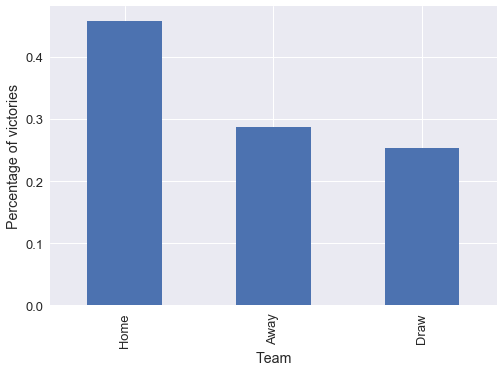

In [56]:
# Produce a plot with the information computed above
sns.set()
sns.set_context('notebook', font_scale=1.3)

df_matches['match_winner'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Team')
plt.ylabel('Percentage of victories')

According to the results, the home team won more than 45% of the matches recorded in this database. Given that the database contains data from more than 25000 matches, spread over 8 seasons and for 11 different countries &mdash; i.e. the data represents a considerably large sample of the population, it seems reasonable to assume that teams have a bigger chance of winning a match when playing home. This can be due to many factors, such as having the support of their own fans, cheering for them during the match, or because they are more used to playing on that particular field; this point, however, is beyond the scope of this analysis.

The next point I want to look at is to find out if this trend exists in all the leagues present in the database. Since the percentages given above are computed for the complete database, it might as well be that there are large variations between the different countries which, when averaged, give the results shown above. For this, I will compute the percentages of home and away wins, as well as draws, for all the countries.

In [57]:
# Get the percentages victories (home, away, draw) separated by country and store in dataframe
df_match_winner = df_matches.groupby(['country_name'])['match_winner'].value_counts(normalize=True).to_frame()
df_match_winner.head()

match_winner
country_name match_winner              
Belgium      Home              0.468750
             Away              0.285301
             Draw              0.245949
England      Home              0.457237
             Away              0.285197

To make the plotting of the results easier, I want to have the different variables stored as columns of the dataframe instead of indices.

In [58]:
# Rename variables and set the indices as columns
df_match_winner.rename(columns={'match_winner':'percentage_wins'},inplace=True)
df_match_winner.reset_index(level=[0,1],inplace=True)
df_match_winner

,country_name,match_winner,percentage_wins
0,Belgium,Home,0.468750
1,Belgium,Away,0.285301
2,Belgium,Draw,0.245949
3,England,Home,0.457237
4,England,Away,0.285197
5,England,Draw,0.257566
6,France,Home,0.447039
7,France,Draw,0.282566
8,France,Away,0.270395
9,Germany,Home,0.452206


The table above could be enough to perform the analysis, however, since the table is relatively large it is not easy to draw the right conclusions. For this reason, I will plot the percentage of home victories for each of the countries, to see if it is consistent with the values obtained for the complete database.

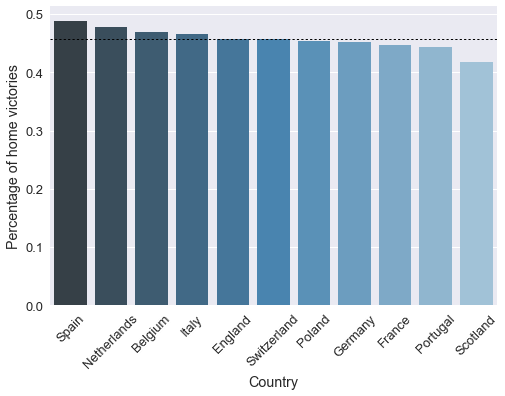

In [59]:
# Plot the percentage of victories for home teams for each country plus the average of all countries
sns.barplot(x='country_name', y='percentage_wins', palette='Blues_d',
            data=df_match_winner[df_match_winner['match_winner']=='Home'].sort_values(by=['percentage_wins'], 
                                                                                      ascending=False))
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Percentage of home victories')
plt.axhline(y=df_match_winner[df_match_winner['match_winner']=='Home']['percentage_wins'].mean(), 
            linewidth=1, ls=':',color='k')

As mentioned, this plot shows the percentage of home victories achieved in each individual country and compares it to the average percentage of home victories obtained before. 

As it can be seen, all the countries present a similar level of home victories, with a variation within $\pm$ 5% of the global average, which provides more confidence to the assumption made above that teams playing home have a larger chance of winning the match. However, it could be the case that in countries with a lower percentage of home victories &mdash; e.g. Scotland &mdash; the percentage of away victories reaches the same or even a higher level than the home victories, which would contradict the assumption made. For this, I will plot the percentages of home victories, away victories and draws for three different countries: Scotland, with the lowest home wins percentage; Spain, with the largest one; and England, which lies more or less around the average.

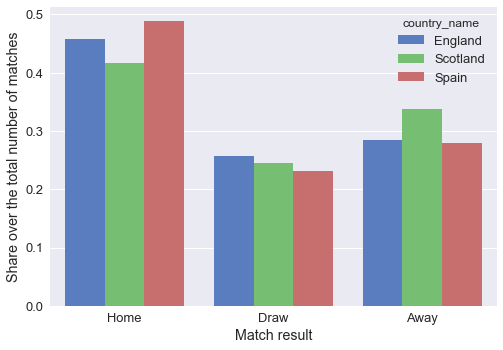

In [60]:
# Plot the percentage of victories for home teams for each country plus the average of all countries
countries_list = ['Spain', 'England', 'Scotland']
sns.barplot(x='match_winner', y='percentage_wins', palette='muted', order=['Home', 'Draw', 'Away'], hue='country_name',
            data=df_match_winner[df_match_winner['country_name'].isin(countries_list)])
plt.xlabel('Match result')
plt.ylabel('Share over the total number of matches')

Even though the percentage of away victories in Scotland is slightly larger than in the other two countries, there is still a significant different between the levels of home and away victories. This confirms that even in the country with the lowest rate of home victories, the teams playing home win more matches than the away teams.

One interesting point that can be observed in previous two graphs is that, even though all the countries show a similar pattern, there are some countries which present slightly larger percentages of home victories than others. This could mean that the so-called home advantage is stronger in some countries than in others. In particular, Spanish teams playing home win about 49% of the matches, whereas in Scotland, the percentage of home victories does not even reach 42%. The explanation of this fact is outside the scope of this study, however, if I were to try to find an explanation for this, I would probably want to look at data such as the percentage of attendance of away fans in the stadiums (less fans of the away team in the stadium might make it easier for the home team to win) or the dimensions and other conditions of the playing fields (less homogeneous fields might lead to a larger home advantage).

After looking at the percentage of home and away victories, the next point that I want to deal with is whether the teams playing home score more goals than the away teams. For this, I will follow a similar approach as before, looking first at the global averages and then segregating the results per country.

In [61]:
# Compare global statistics of goals obtained by home and away teams
df_matches[['home_team_goal', 'away_team_goal']].describe()

,home_team_goal,away_team_goal
count,25979.000000,25979.000000
mean,1.544594,1.160938
std,1.297158,1.142110
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,9.000000


The average results show that, in general, the home teams score more goals per match than the away teams (around 0.5). Also, the higher standard deviation indicates a higher dispersion in the distribution of the goals scored by the home teams, which, considering the average of goals per match, might mean that seeing a home team scoring 3 or 4 goals in a match is less unusual than for a team playing away.

Next, I want to group the data for each country and see if the results are consistent with the global averages.

In [62]:
# Geat the mean of home and away goals per match for each country
df_matches.groupby(['country_name'])[['home_team_goal', 'away_team_goal']].mean().sort_values(by=['home_team_goal'],ascending=False)

,home_team_goal,away_team_goal
country_name,,
Netherlands,1.779820,1.301062
Switzerland,1.663150,1.266526
Spain,1.631250,1.135855
Germany,1.626634,1.274918
Belgium,1.609375,1.192130
England,1.550987,1.159539
Italy,1.500829,1.116009
Scotland,1.429276,1.204496
Portugal,1.408382,1.126218


The results show that, in all countries, the home teams tend to score more goals than the away teams.

It is interesting to observe that the country with the highest percentage of home victories (i.e. Spain) is not the country where home teams score the most goals per match (i.e. the Netherlands). Similarly, the home teams in Scotland (the league with the lowest home victories' rate) are not the ones that score the least goals per match. This seems to indicate that the percentage of home victories is not necessarily directly correlated to the number of goals scored by the home team. In the next steps, I want to look a little bit further into this and see how the percentage of home victories correlates with the amount of goals scored. For this, I will add two new variables to the matches dataframe: the total number of goals scored per match and the difference in goals between the home team and the away team.

In [63]:
# Add two columns to the original dataframe with the total number of goals per match and the goal difference
df_matches['total_num_goals'] = df_matches['home_team_goal'] + df_matches['away_team_goal']
df_matches['goal_difference'] = df_matches['home_team_goal'] - df_matches['away_team_goal']

In [64]:
# Get mean values of home goals, away goals, total number of goals and goal difference per match for each country
df_goals_per_country = df_matches.groupby(['country_name'])[['home_team_goal', 'away_team_goal', 'total_num_goals', 
                                                             'goal_difference']].mean().sort_values(by=['goal_difference']).copy()
df_goals_per_country

,home_team_goal,away_team_goal,total_num_goals,goal_difference
country_name,,,,
Scotland,1.429276,1.204496,2.633772,0.224781
Portugal,1.408382,1.126218,2.534600,0.282164
Germany,1.626634,1.274918,2.901552,0.351716
France,1.402961,1.040132,2.443092,0.362829
Poland,1.394792,1.030208,2.425000,0.364583
Italy,1.500829,1.116009,2.616838,0.384819
England,1.550987,1.159539,2.710526,0.391447
Switzerland,1.663150,1.266526,2.929677,0.396624
Belgium,1.609375,1.192130,2.801505,0.417245


It is interesting to see that the countries with the largest and lowest rates of home victories &mdash; Spain and Scotland, respectively &mdash; are precisely those with the largest and lowest averages of difference in goals between home and away teams. This might indicate that there is a correlation between these two variables. For this, I will add the percentage of home victories to this dataframe and see how they compare.

In [65]:
# Add a column with the percentage of home victories for each country
df_goals_per_country = df_goals_per_country.join(df_match_winner[df_match_winner['match_winner']=='Home'].set_index('country_name')['percentage_wins'])
df_goals_per_country.sort_values(by=['percentage_wins'], ascending=False)

,home_team_goal,away_team_goal,total_num_goals,goal_difference,percentage_wins
country_name,,,,,
Spain,1.631250,1.135855,2.767105,0.495395,0.488487
Netherlands,1.779820,1.301062,3.080882,0.478758,0.478350
Belgium,1.609375,1.192130,2.801505,0.417245,0.468750
Italy,1.500829,1.116009,2.616838,0.384819,0.466357
England,1.550987,1.159539,2.710526,0.391447,0.457237
Switzerland,1.663150,1.266526,2.929677,0.396624,0.457103
Poland,1.394792,1.030208,2.425000,0.364583,0.453125
Germany,1.626634,1.274918,2.901552,0.351716,0.452206
France,1.402961,1.040132,2.443092,0.362829,0.447039


In order to see how the different variables compare I will first compute the correlation matrix using Pandas .corr() function, which provides the standard correlation between all the available variables, and then I will use the Seaborn library to produce the scatter plots between all columns, which gives a qualitative indication of the correlation between variables.

In [66]:
# Compute the standard correlation between the different columns shown above
df_goals_per_country.corr(method='pearson')

,home_team_goal,away_team_goal,total_num_goals,goal_difference,percentage_wins
home_team_goal,1.000000,0.803252,0.965870,0.718069,0.667856
away_team_goal,0.803252,1.000000,0.930123,0.162242,0.119545
total_num_goals,0.965870,0.930123,1.000000,0.513287,0.463760
goal_difference,0.718069,0.162242,0.513287,1.000000,0.966704
percentage_wins,0.667856,0.119545,0.463760,0.966704,1.000000


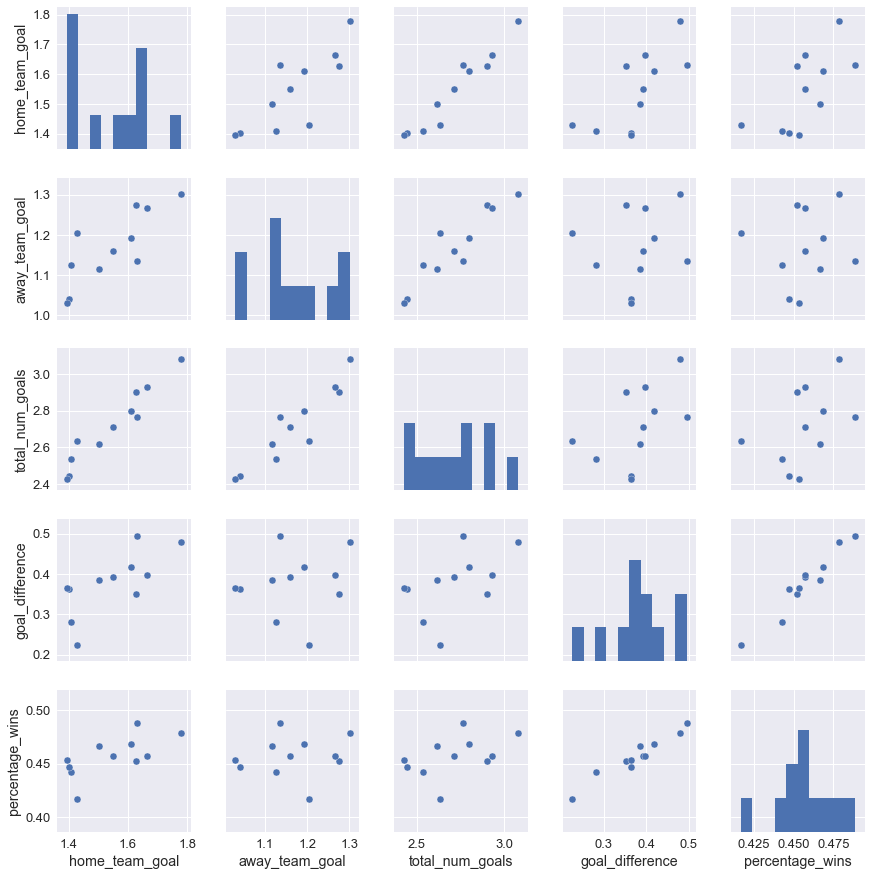

In [67]:
# Produce scatter plots for all possible combination of variables
sns.pairplot(df_goals_per_country)

The results seem to agree with the abovementioned observation that the percentage of victories is not strongly correlated either to the average of home goals nor the average of away goals, but rather to the average of the difference between these two. 

To make this clearer, I will plot these two variables together with a linear regression.

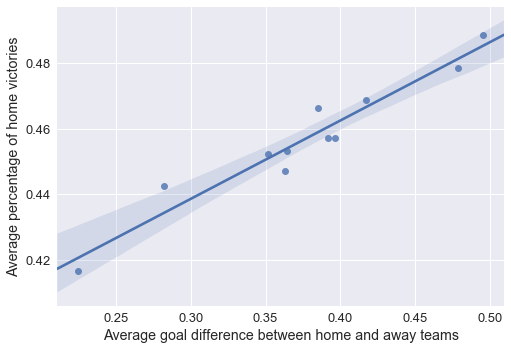

In [68]:
# Plot the average goal difference between home and away teams vs. the percentage of home victories for all countries
sns.regplot(x='goal_difference', y='percentage_wins', data=df_goals_per_country)
plt.xlabel('Average goal difference between home and away teams')
plt.ylabel('Average percentage of home victories')

As it can be observed, there is a strong correlation between both variables. This means that the countries where the home teams win more matches, are also those where the victories of the home teams are obtained by a larger difference in goals, and vice versa.

To sum up, the results shown here indicate that the teams playing home win generally more matches than the visiting teams and that they also score more goals per match. This trend seems to be present in all countries available in the database. We have also observed that, when analyzing the data segregated by country, there is a correlation between the percentage of matches won by the home teams and the average goal difference between the home and away teams.

One thing that I have not looked into, however, are the results separated by teams. This might show somewhat different trends. For example, it might show that some teams have a very large percentage of home victories with respect to the rest of the teams in their league, altering the average of the rate of home victories for that country. It could be the case for Spain, for example, where a couple of very strong teams such as FC Barcelona or Real Madrid CF &mdash; who win most of their matches &mdash; could be increasing the overall percentage of home victories for the country. Nevertheless, for the sake of concision, I will not look further into this and will tackle the next question.

<a id='eda2'></a>
### 3.b Question 2: What is the effect of the ball possession percentage?

The next question that I want to address is the influence of the ball possession percentage in the matches' results. As mentioned before, over the past decade the ball possession has become a recurring topic in football discussions &mdash; both in the press and in the private sphere &mdash; for this reason, I want to make use of the available data to find out whether controlling the ball possession is really essential to win.

The strategy that I will follow is similar to the one used before: I will first look at the global averages of ball possession and afterwards I will group the data by country, to see if the results are consistent with the global averages or if there are any biases.

The first step is to compute the average of ball possession for all the teams together, separating only between the different types of results: victory, draw and defeat.

In [69]:
# Get the average possession for each type of result: Win, Draw, Loss
df_matches_merged.groupby(['match_result'])['possession'].mean()

match_result
Draw    50.000000
Loss    48.003799
Win     51.996201
Name: possession, dtype: float64

Looking at the global average, it seems that the winning teams tend to have a slightly larger ball possession than the losing teams.

However, as we saw before, the available possession data was not homogeneously distributed across all leagues and only four of them contained an almost complete database of ball possession percentages. In order to compare results from countries with similar amounts of data &mdash; thus trying to prevent incomplete datasets from altering the results &mdash; I will focus my analysis only in the data of these four countries: England, Spain, Italy and Germany.

In [70]:
# Create a dataframe with only the data of the countries with enough possession data
countries_with_possession = ['England', 'Spain', 'Italy', 'Germany']
df_for_possession = df_matches_merged[df_matches_merged['country_name'].isin(countries_with_possession)].copy()

# Print out the average possession for each result type
df_for_possession.groupby(['match_result'])['possession'].mean()

match_result
Draw    50.000000
Loss    47.872271
Win     52.127729
Name: possession, dtype: float64

We can see that, although the new mean possession values are slightly different, the trend is the same as above &mdash; the winning teams achieved in average more possession than the losing teams.

The next step that I want to do is to group the data by country and see how they compare with respect to the overall average.

In [71]:
# Compute the average possession levels for each result type and country
df_for_possession.groupby(['country_name','match_result'])['possession'].mean()

#df_possession_mean = df_for_possession.groupby(['country_name','match_result'])['possession'].mean().to_frame().reset_index()

country_name  match_result
England       Draw            50.000000
              Loss            47.645204
              Win             52.354796
Germany       Draw            50.000000
              Loss            49.076100
              Win             50.923900
Italy         Draw            50.000000
              Loss            48.229551
              Win             51.770449
Spain         Draw            50.000000
              Loss            47.155608
              Win             52.844392
Name: possession, dtype: float64

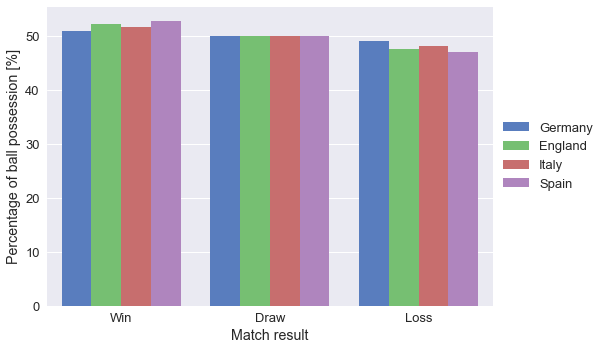

In [72]:
# Plot the average possession levels for each result type and country
sns.barplot(x='match_result', y='possession', hue='country_name', palette='muted', ci=None, data=df_for_possession,
            order=['Win', 'Draw', 'Loss'])
plt.xlabel('Match result')
plt.ylabel('Percentage of ball possession [%]')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

As we can see, the trend is consistent between countries: winning teams tend to have more possession than losing teams. Nevertheless, the difference in possession percentage between winning and losing teams is relatively small &mdash; less than 5% in average &mdash; which makes it difficult to confirm whether controlling the ball possession is really a key factor to winning or not. 

Additionally, it can be seen that, despite the small differences between winners and losers, the averages of ball possession are different in all four countries. In particular, the difference in possession between winning and losing teams for Germany is below 2%, whereas in Spain it goes up to almost 6%. This could mean that controlling the ball possession has a larger impact in the chance of winning in Spain than in Germany, which could, in turn, be related to the different kind of football played in each country.

One point which I found strange at the beginning is that the average possession for the draws was always equal to 50%. This is nonetheless correct, since the way I have grouped the results by (Win, Draw, Loss) means that for either wins or defeats there is only one team per match accounted for. In the case of draws, however, both teams are taken into account and, therefore, the average possession percentage is exactly 50%. This means, of course, that the abovementioned possession averages are only representative for victories and defeats, and not for draws.

Finally, I want to see if the ball possession has an influence on the number of goals scored and in the number of goals conceded. For this, I will simply plot the possession percentages grouped by number of goals scored using a box plot. The reason for using a box plot is that it not only allows for an identification of the median values of the variable to be analyzed, but also for the dispersion of the same, which can also provide an idea of the size of the sample.

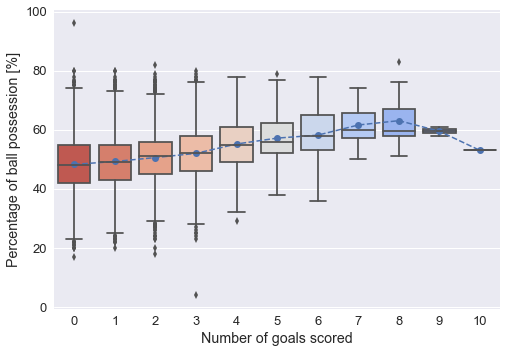

In [73]:
# Plot the ball possession grouped by number of goals scored using a Box plot
sns.boxplot(x='num_goals_for', y='possession', palette='coolwarm_r', data=df_for_possession)
plt.plot(df_for_possession.groupby(['num_goals_for'])['possession'].mean(), marker='o', ms=7, ls='--', lw=1.5)
plt.xlabel('Number of goals scored')
plt.ylabel('Percentage of ball possession [%]')

In addition to the typical boxes and whiskers from this kind of plots, I have added a line representing the mean possession percentage for each segment, in order to add confidence to the results. It is interesting to note that both mean and median seem to be quite similar for most of the segments, except on those corresponding to a high number of goals scored, which indicates that most of the data are quite symmetrically distributed around the median.

The plot clearly shows that the teams scoring a higher number of goals tend to have more control of the ball. However, one aspect to take into account is that the size of the samples for the segments above 6 goals scored seem to be relatively small compared to the rest &mdash; deduced from the smaller dispersion and larger skewness of the distributions &mdash; indicating that we should not trust too much the trend in this area, and only focus on the previous segments. To check this, I will get the exact number of occurrences for each segment of goals scored.

In [74]:
# Get the number of occurrences for each amount of goals scored
df_for_possession['num_goals_for'].value_counts()

1     7607
0     6434
2     5158
3     2485
4      958
5      311
6       95
7       26
8       12
9        3
10       1
Name: num_goals_for, dtype: int64

As expected, the number of teams who have scored more than 6 goals in one match is relatively small (only 42 occurrences in this subset of the database). This result is coherent, as scoring such a large number of goals in one match is extremely difficult and thus, very rare. In any case, even when analyzing only the results up to 6 goals scored, the trend is clear: the higher the amount of goals scored by a team, the larger the ball possession (in average).

Given the nature of the data, I expect the trend of the possession vs. the number of goals received to be the opposite of the one shown before, as the goals conceded by a given team are, in the end, the goals scored by another team in the database. Nevertheless, I will plot these variables for checking.

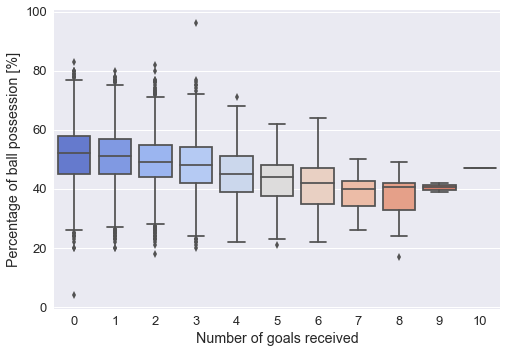

In [75]:
# Plot the ball possession grouped by number of goals received using a Box plot
sns.boxplot(x='num_goals_against', y='possession', palette='coolwarm', data=df_for_possession)
plt.xlabel('Number of goals received')
plt.ylabel('Percentage of ball possession [%]')

The plot confirms the expected trend: the more goals conceded by a team, the less share of ball possession the team had in the match.

The analysis performed in this section has shown that, in average, the winning teams have a higher percentage of ball possession than the losing teams, and that this trend is true for all the countries considered (Spain, England, Italy and Germany). Furthermore, we have seen that the teams which score a higher number of goals in a match tend to have the control of the ball for longer periods of the playing time.

Given that I have not done any statistical testing, however, I cannot conclude anything on the real influence of the possession in the chances of winning of a team in any given match.

It is also worth mentioning that the results herein shown are directly impacted by the choice made earlier on when retrieving the ball possession values from the corresponding XML strings (see section <a href="#wrangling3">2.c</a>). I made the assumption then that the last value given for each match corresponded to the average possession for the match. Since I found no information concerning this point, it might as well be that this assumption was not correct, in which case, the results of my analysis would be wrong as well.

<a id='eda3'></a>
### 3.c Question 3: What is the effect of the team formation?

Finally, the last question that I want to analyze is the influence of the team formation in the results. I will start by looking at the percentage of victories for all the formation types identified in the database to see how they compare to each other, and then I will study the influence of each individual formation line &mdash; defense, midfield and attack &mdash; on its most relevant variable, i.e. goals conceded, ball possession and goals scored, respectively.

To begin with, I want to see how many occurrences there are in the database for each formation, in order to have a feeling of the order of magnitude before analyzing the results.

In [76]:
# Print out the number of occurrences for each formation
df_matches_merged['formation'].value_counts()

1-4-4-2        17110
1-4-5-1        16894
1-4-3-3        10786
99-99-99-99     3678
1-3-5-2         1680
1-3-4-3         1198
1-5-3-2          384
1-5-4-1          207
1-3-6-1           21
Name: formation, dtype: int64

As we can see, those with 4 defenders are the most commonly used formations in the latest years in European football. We can also see that the formations with 5 defenders represent only a small share of the total, as well as the 3-6-1 formation, from which there are only 21 cases. It is important to keep this in mind for the analysis, as the results might be biased by the small size of the samples for these formations.

Before starting the analysis, I want to remove all the matches with missing or faulty formations, i.e. the lines where the formation is equal to 99-99-99-99.

In [77]:
# Create a dataframe without the 99-99-99-99 formations
df_for_formations = df_matches_merged[df_matches_merged['formation']!='99-99-99-99'].copy()
df_for_formations['formation'].value_counts()

1-4-4-2    17110
1-4-5-1    16894
1-4-3-3    10786
1-3-5-2     1680
1-3-4-3     1198
1-5-3-2      384
1-5-4-1      207
1-3-6-1       21
Name: formation, dtype: int64

For the first step of the analysis, I want to compute the percentage of each result type (win, defeat, draw) for each formation type, and I will save it into a new dataframe in order to make the plotting easier.

In [78]:
# Create dataframe with the percentage of victories, defeats and draws for each formation
df_formation_results = df_for_formations.groupby(['formation'])['match_result'].value_counts(normalize=True).to_frame()

In [79]:
# Rename variables and set the indices as columns
df_formation_results.rename(columns={'match_result':'result_percentage'}, inplace=True)
df_formation_results.reset_index(level=[0,1],inplace=True)
df_formation_results.head()

,formation,match_result,result_percentage
0,1-3-4-3,Win,0.371452
1,1-3-4-3,Loss,0.348080
2,1-3-4-3,Draw,0.280467
3,1-3-5-2,Loss,0.380952
4,1-3-5-2,Win,0.354762


Additionally, I want to add the total number of cases found in the database for the combination of each formation and result type, as well as the total number of times each formation was used. I will use this when plotting the results to take into account the size of the samples.

In [80]:
# Add a column to the dataframe with the number of occurrences for each row
df_formation_result_counts = df_for_formations.groupby(['formation'])['match_result'].value_counts().to_frame()
df_formation_result_counts.rename(columns={'match_result':'result_counts'},inplace=True)
df_formation_result_counts.reset_index(level=[0,1],inplace=True)

df_formation_results = pd.merge(df_formation_results, df_formation_result_counts, on=['formation', 'match_result'])
df_formation_results.head()

,formation,match_result,result_percentage,result_counts
0,1-3-4-3,Win,0.371452,445
1,1-3-4-3,Loss,0.348080,417
2,1-3-4-3,Draw,0.280467,336
3,1-3-5-2,Loss,0.380952,640
4,1-3-5-2,Win,0.354762,596


In [81]:
df_formation_results = pd.merge(df_formation_results, df_for_formations['formation'].value_counts().to_frame(), 
                                left_on='formation', right_index=True, suffixes=('_x', '_counts')).drop('formation_x', axis=1)
df_formation_results

,formation,match_result,result_percentage,result_counts,formation_counts
0,1-3-4-3,Win,0.371452,445,1198
1,1-3-4-3,Loss,0.348080,417,1198
2,1-3-4-3,Draw,0.280467,336,1198
3,1-3-5-2,Loss,0.380952,640,1680
4,1-3-5-2,Win,0.354762,596,1680
5,1-3-5-2,Draw,0.264286,444,1680
6,1-3-6-1,Win,0.476190,10,21
7,1-3-6-1,Loss,0.333333,7,21
8,1-3-6-1,Draw,0.190476,4,21
9,1-4-3-3,Win,0.396811,4280,10786


The first plot that I want to look at is the percentage of victories for each formation (with respect to the total number of times the formation was used). I will sort the columns by the total number of victories of each formation, from the most common to the least one, in order to make it simpler to identify the formations with a very low number of cases.

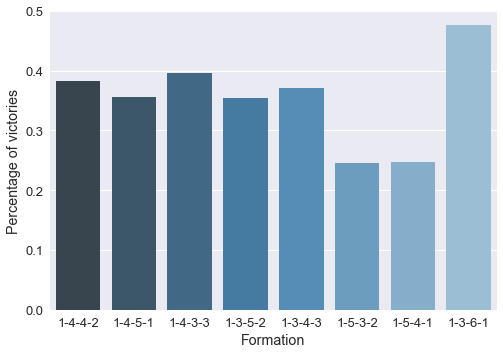

In [82]:
# Plot the percentage of victories for each formation type
sns.barplot(x='formation', y='result_percentage', palette='Blues_d',
            data=df_formation_results[df_formation_results['match_result']=='Win'].sort_values(by=['formation_counts'], ascending=False))
plt.xlabel('Formation')
plt.ylabel('Percentage of victories')

An interesting point that can be observed in the plot is that the first five formations (the most commonly used) present a relatively stable trend, whereas the last three (the least used formations) present values well above or below the other ones. This seems like a clear indication that the size of the sample is influencing the results.

If we look only at the formations with the highest number of occurrences ($\geq$ 1000), we can see that they all present a percentage of victories between 35 and 40%, which is a relatively small range of difference.

In order to dig a little bit more into the data, I will include in the plot the ratios of defeats and draws for each formation.

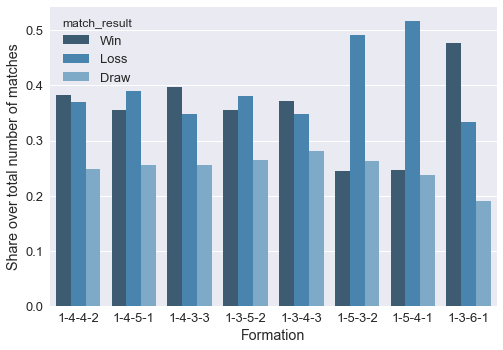

In [83]:
# Plot the percentage of victories, defeats and draws for each formation
sns.barplot(x='formation', y='result_percentage', palette='Blues_d', hue='match_result', 
            data=df_formation_results.sort_values(by=['formation_counts'], ascending=False))
plt.xlabel('Formation')
plt.ylabel('Share over total number of matches')

As before, the most common formations are quite balanced in the ratios of victories and defeats &mdash; with both ranging between 35 and 40% &mdash; which would make it extremely difficult if we had to choose a formation for our team based only on the historical data contained here. Nevertheless, the 4-3-3 seems to have the highest percentage of victories and the lowest of defeats.

One interesting point is that both formations with 5 defenders (the 5-4-1 and the 5-3-2) present a considerably high ratio of defeats &mdash; around 50% or, in other words, they lose almost every other match. This is somewhat surprising, since these formations are usually considered as defensive in football, meaning that they are usually associated to matches where the team is not so much seeking to win but rather not to lose. This could be caused by the fact that this type of formation is normally used by smaller teams when facing teams which are better than them, in order to try not to concede too many goals, but, in the end, the bigger team usually takes the win.

The last step in my analysis will be looking at the influence of the amount of players for each formation line in the parameter of the match most related to that specific line. As an example, I want to see if there is a correlation between the number of midfielders in the line-up and the percentage of ball possession achieved by the team. For this, I will first print how many cases there are available for each possible number of midfielders in the formation. It is worth noticing that for this first point (number of midfielders vs. possession), I will use the subset of the database which contains possession data.

In [84]:
# Print the number of occurrences available in the database for each possible number of midfielders
df_for_formations[df_for_formations['country_name'].isin(countries_with_possession)]['midfielders'].value_counts()

5    10849
4     8372
3     3853
6        8
Name: midfielders, dtype: int64

We can see that, for this subset of the database, most of the teams played with 5 midfielders. Also, we only have 8 cases of formations using 6 midfielders, which will probably affect the results.

As said, I want to plot the percentage of ball possession as a function of the number of midfielders in the line-up.

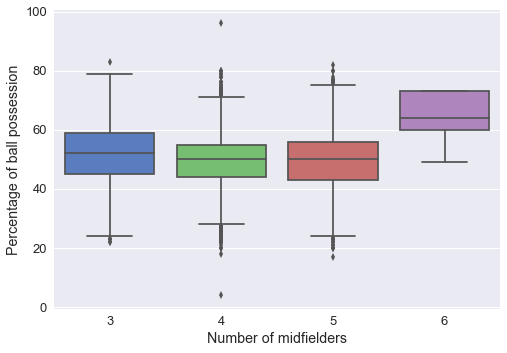

In [85]:
# Box plot with the ball possession for each possible number of midfielders in the formation
sns.boxplot(x='midfielders', y='possession', palette='muted',
            data=df_for_formations[df_for_formations['country_name'].isin(countries_with_possession)])
plt.xlabel('Number of midfielders')
plt.ylabel('Percentage of ball possession')

One would be expect that the more players in the midfield a team lined up in a given match, the more ball possession they would attain at the end of that match, as midfielders are usually the ones in charge of keeping possession of the ball and distributing it along the field. However, from the result above we cannot see a clear trend indicating this. It seems that the ball possession remains more or less constant, regardless of the number of midfielders. The exception comes for the formations with 6 midfielders but, due to the low number of cases available, I would tend not to trust this result.

This result seems to indicate that, in terms of ball possession, it is not so relevant the number of midfielders you line up, but rather how they play &mdash; are they more defensive? More offensive? More technical? &mdash; and the instructions or the strategy given by the manager &mdash; is the team really looking to control the ball, or rather just wait to steal the ball from the opponent and launch a quick counter-attack?. I think this is a good example to show that football, as many other fields, cannot be reduced to just numbers, but there are many other factors which come into play.

Next, I will follow the same process to analyze a possible correlation between the number of forwards in the line-up and the number of goals scored.

In [86]:
# Print the number of occurrences for each possible number of forwards
df_for_formations['forwards'].value_counts()

2    19174
1    17122
3    11984
Name: forwards, dtype: int64

In comparison with the midfielders, the distribution of the forwards seems to be more balanced, which means that the numbers obtained will be statistically significant in all the cases.

As before, I will plot the average of the goals scored for each of the possible number of forwards in the line-up.

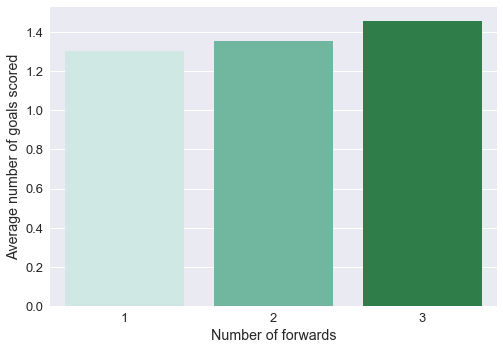

In [87]:
# Bar plot with average of goals scored for each possible number of forwards in the formation
sns.barplot(x='forwards', y='num_goals_for', palette='BuGn', data=df_for_formations, ci=None)
plt.xlabel('Number of forwards')
plt.ylabel('Average number of goals scored')

The results show an increasing trend of the goals scored with the number of forwards in the team formation, in other words, the teams playing with 3 strikes scored, in average, more goals than those playing with 2 or 1. It is interesting to see that in the case of the forwards, lining up more players in this part of the formation seems to have a positive effect in the performance of the team, unlike the midfield and the ball possession.

Finally, I will do the same thing to analyze the number of goals conceded versus the number of defenders in the line-up.

In [88]:
# Print the number of occurrences for each possible number of defenders
df_for_formations['defenders'].value_counts()

4    44790
3     2899
5      591
Name: defenders, dtype: int64

By looking at the number of cases for each amount of defenders, we can observe that the distribution is not very balanced, as the number of teams that have used 4 defenders is significantly larger than those using 3 or 5 defenders. This might be an issue in particular for the results with 5 defenders, as the number of cases available is relatively low.

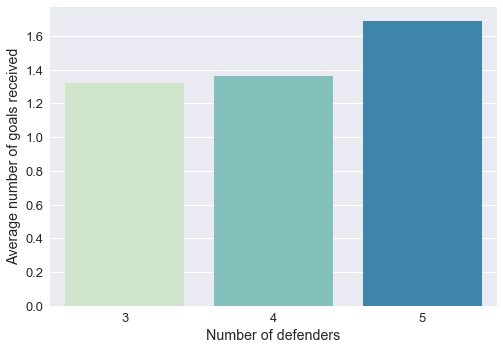

In [89]:
# Plot the average number of goals conceded for each possible number of forwards in the formation
sns.barplot(x='defenders', y='num_goals_against', palette='GnBu', data=df_for_formations, ci=None)
plt.xlabel('Number of defenders')
plt.ylabel('Average number of goals received')

Contrary to what could be expected, the results show that teams playing with 5 defenders receive, in average, more goals than those playing with 4 or 3. However, as noted above, the values for 5 defenders should be treated with care, since the number of cases available is considerably lower than for the other two defense types.

All in all, the results presented in this section seem to indicate that the formation alone cannot be used as a predictor of the performance of a team: first, there seems to be no single formation which achieves a significantly higher percentage of victories than the rest; also, teams playing with more midfielders do not generally achieve higher levels of ball possession than those with less players in that area; and finally, more populated defensive lines do not lead the team to receive less goals. On the contrary, teams playing with more strikers have a higher average of goals scored. 

As mentioned above, these results seem to indicate that there are additional factor influencing the performance of the teams other than the formation type chosen by the manager. Some examples of those factors that are not accounted for could be: the strategy used by the team (e.g. controlling the ball possession vs. pressing and counterattacking); the raw talent of the players of each team (a team playing with 3 very good midfielders will probably have more possession than a team with 5 average midfielders); or even the overall physical condition of the squad.

Nevertheless, I would like to bring the attention to two points which could be influencing the results of this analysis. The first one is that, when generating the variables containing the formation of each team, I assigned the players to each formation line based on the y-position given in the database. Since this is a convention selected by me, it could be that it does not apply to all of the teams. For example, one player could have a y-position value of 5 and, therefore, be considered as a midfielder in my analysis, but in reality he might have played as a defender. Therefore, it is not possible to be certain that the distribution of the formations is 100% accurate.

Secondly, the y-positions given in the database correspond most likely to the formation of the team at the beginning of the match. However, in football it is allowed (and very common) to substitute players during the match, up to three per team. This means that any given team might have changed the formation during the match &mdash; thus probably affecting the final result &mdash; but this is not taken into account in this analysis.

<a id='conclusions'></a>
## 4. Conclusions

To conclude, I would like to summarize the findings of my analysis. First, I analyzed the possible existence of a home advantage, for which I looked at the percentage of victories by the home teams versus the away teams, as well as the goals scored and received by these. The results showed that the teams playing home win, in average, more matches than the away teams. This trend is present in all the countries available in the database, although with a difference of about 7% between the country with the largest share of home victories and the one with the lowest one. Then, we confirmed that the home teams tend to score more goals than the away teams (i.e. a higher average of goals scored). Finally, we discovered that the countries where the home teams have a larger share of victories, are also those where the victories of the home teams are obtained by a larger difference in goals, and vice versa.

Afterward, I studied the differences in ball possession percentage between winning and losing teams, as well as distribution of ball possession based on the number of goals scored by the teams. This part of the analysis showed that, although only by a small amount, the teams winning the matches tend to have more possession of the ball than the teams losing. This is the case for all the four countries analyzed, even if there were small differences between them. Additionally, we saw that the teams which score a higher number of goals in a match tend to have the control of the ball for longer periods of the match and that the opposite is true when analyzing the number of goals received. These results seem to indicate that ball possession might have an impact on the outcome of the match, however, since I have not done any statistical testing, I cannot draw any conclusions on this.

Finally, I analyzed the performance of the teams based on the formation they used; first, by looking at the overall percentage of victories and defeats of each formation, and then by investigating the correlation between the number of players in each formation line and the most relevant variable for that line. The results showed that there is no single formation which achieves a significantly higher percentage of victories than the rest. However, it was interesting to see that the formations using 5 defenders had a substantially higher rate of defeats than the others. Additionally, we observed that teams playing with more midfielders do not obtain higher percentages of ball possession, that teams lining up more players in defense do not receive less goals and, finally, that teams playing with more forwards tend to score more goals.

As mentioned before, this study was not meant to understand the cause between the different correlations (e.g. home teams winning more matches than away teams), but to find out whether these correlations are backed by evidence or not. Also, it is worth noting that without carrying out a proper statistical testing, it is not possible to make predictions for the future and, therefore, the results concluded here are only representative of the data included in the database.

<a id='references'></a>
## 5. References

<ol>
<li><a id='ref1'>https://www.kaggle.com/hugomathien/soccer</a></li>
<li><a id='ref2'>https://www.kaggle.com/chinmaypai/data-wrangling-to-extract-match-stats</a></li>
<li><a id='ref3'>https://www.kaggle.com/hugomathien/soccer/discussion/30200</a></li>
<li><a id='ref4'>https://stackoverflow.com/questions/3973819/python-pretty-xml-printer-for-xml-string</a></li>
</ol>